In [1]:
import os
import subprocess

import pandas as pd
print(pd.__name__, pd.__version__)

import numpy as np
print(np.__name__, np.__version__)

import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__name__, matplotlib.__version__)

import scipy.stats as stats
import scipy
print(scipy.__name__, scipy.__version__)


from collections import Counter
#import regex as regex

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
pandas 1.2.1
numpy 1.19.2
matplotlib 3.3.2
scipy 1.5.2


## Basic Function and Data Imports

In [3]:
def reverse_complement(dna):
    """ function that reverse complements DNA
    dna: input dna sequence
    """
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'}
    return ''.join([complement[base] for base in dna[::-1]])

def get_dict_of_seq(fasta_file):
    """ function that converts a fasta file to a dictionnary of sequences
    fasta_file: the input fasta file
    """
    
    file_fasta_dict = {}
    # output dict of imported seqs
    
    with open(fasta_file, 'r') as fasta:    
        for line in fasta:
            # loops through the file

            if line.startswith('>') == True:
                seq_info = line.strip('>').strip('\n').split('\t')[0]
                file_fasta_dict[seq_info] = ''
                # checks if seq header

            else:
                file_fasta_dict[seq_info] += line.strip('\n')
                # If not, append nt to current seq
                
    return file_fasta_dict


universal_seqs_fasta = "./uni_amplicon_sequences/universal_amplicon.fa"
universal_seqs = get_dict_of_seq(universal_seqs_fasta)
print(universal_seqs)

indexes_fasta = "./uni_amplicon_sequences/indexes.fa"
indexes = get_dict_of_seq(indexes_fasta)
print(indexes)

degen_seq = 'AAAAA'

{'Index_five_prime': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCTNNNNN', 'Index_three_prime': 'NNNNNAGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG', 'plate_fivep_sticky': 'TAACTTACGGAGTCGCTCTACG', 'RC_fivep_sticky': 'CCATACGAGCACATTACGGG', 'plate_threep_sticky': 'CAGGACCTAAAGAATCCCATCC', 'RC_threep_sticky': 'CCTCAGTCGCTCAGTCAAG', 'five_prime_adapter': 'AATGATACGGCGACCACCGAGATCTACACTCTTTCCCTACACGACGCTCTTCCGATCT', 'three_prime_adapter': 'AGATCGGAAGAGCGGTTCAGCAGGAATGCCGAGACCGATCTCGTATGCCGTCTTCTGCTTG'}
{'1': 'CAAGTGTTC', '2': 'AGGACATTC', '3': 'CACTAATGG', '4': 'AGCCTGATG', '5': 'TTACGCTAA', '6': 'ACTCTCCGT', '7': 'GTCGATGCA', '8': 'ACGGGAATT', '9': 'CGCGCCCAG', '10': 'ACTAGTTTG', '11': 'AGTATTACA', '12': 'AGGTTGGGT', '13': 'GTGAACCGA', '14': 'GCACAAAAC', '15': 'CTGTCTTCG', '16': 'GACGCGACT', '17': 'CAGCCCATA', '18': 'AGATATCTG'}


### Check sequencing quality and select for seqs w/ correct length

In [4]:
experiment_name = 'miseq_03_03_2022'

path_to_R1_file = './data/FCY1_5FC_R1.fastq.gz'

path_to_R2_file = './data/FCY1_5FC_R2.fastq.gz'

In [6]:
subprocess.check_output('fastqc '+path_to_R1_file, shell=True)
#                                  path to the R1 (forward) compressed sequencing file
subprocess.check_output('fastqc '+path_to_R2_file, shell=True)
#                                  path to the R2 (reverse) compressed sequencing file

b'Analysis complete for Undetermined_S0_L001_R2_001.fastq.gz\n'

In [17]:
trim_call = 'java -jar ../../../../Downloads/Trimmomatic-0.39/trimmomatic-0.39.jar PE -threads 6 -trimlog log.txt '
trim_call += path_to_R1_file+' '+path_to_R2_file+' '+'-baseout ./temp/minlen299.fastq MINLEN:285 CROP:250'

trim_call

'java -jar ../../../../Downloads/Trimmomatic-0.39/trimmomatic-0.39.jar PE -threads 6 -trimlog log.txt ./data/Undetermined_S0_L001_R1_001.fastq.gz ./data/Undetermined_S0_L001_R2_001.fastq.gz -baseout ./temp/minlen299.fastq MINLEN:285 CROP:250'

In [18]:
subprocess.check_output(trim_call, shell=True)

b''

In [19]:
subprocess.check_output('fastqc '+'./temp/minlen299_1P.fastq', shell=True)
subprocess.check_output('fastqc '+'./temp/minlen299_2P.fastq', shell=True)


b'Analysis complete for minlen299_2P.fastq\n'

### check abundance of libraries

In [20]:
if 'amplicon_sequences' not in os.listdir():
    os.mkdir('./amplicon_sequences')
    
if 'bowtie_indexes' not in os.listdir():
    os.mkdir('./bowtie_indexes')

In [21]:
plate_index_pair_list = [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3), (3,1), (3,2), (3,3)]

plate_pcr_amplicon_for = './amplicon_sequences/plate_pcr_for.fa'
plate_pcr_amplicon_rev = './amplicon_sequences/plate_pcr_rev.fa'

for_plate_indexes = [1,2,3]

rev_plate_indexes = [1,2,3]

print(for_plate_indexes)
print(rev_plate_indexes)


with open(plate_pcr_amplicon_for, 'w') as fasta_out:
    
    for index in for_plate_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = degen_seq+index_seq+universal_seqs['plate_fivep_sticky']+'\n'
        fasta_out.write(amplicon_frag)
        
        
for_plate_index = './bowtie_indexes/'+experiment_name+'_for_plate'
for_plate_bowtie_index_call = 'bowtie-build -f -r -o 4 '+plate_pcr_amplicon_for+' '+for_plate_index
for_plate_indexing_log = subprocess.check_output(for_plate_bowtie_index_call, shell=True)
        
        
with open(plate_pcr_amplicon_rev, 'w') as fasta_out:
    
    for index in rev_plate_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = degen_seq + index_seq+ reverse_complement(universal_seqs['plate_threep_sticky'])+'\n'
        fasta_out.write(amplicon_frag)    
    
rev_plate_index = './bowtie_indexes/'+experiment_name+'_rev_plate'
rev_plate_bowtie_index_call = 'bowtie-build -f -r -o 4 '+plate_pcr_amplicon_rev+' '+rev_plate_index
rev_plate_indexing_log = subprocess.check_output(rev_plate_bowtie_index_call, shell=True)

[1, 2, 3]
[1, 2, 3]


## align for barcode

In [22]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 230 --trim5 5 --norc --chunkmbs 256 '
# adjusted for 30pb trimming
test_align_call += for_plate_index+' '
test_align_call += './temp/minlen299_1P.fastq '
test_align_call += './temp/plate_for_align.txt'

print (test_align_call)

subprocess.check_output(test_align_call, shell = True)

bowtie -t -v 3 -p 6 -k 1 --trim3 230 --trim5 5 --norc --chunkmbs 256 ./bowtie_indexes/miseq_03_03_2022_for_plate ./temp/minlen299_1P.fastq ./temp/plate_for_align.txt


b''

In [23]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 230 --trim5 5 --norc --chunkmbs 256 '
# adjusted for 30pb trimming
test_align_call += rev_plate_index+' '
test_align_call += './temp/minlen299_2P.fastq '
test_align_call += './temp/plate_rev_align.txt'
print (test_align_call)
subprocess.check_output(test_align_call, shell = True)

bowtie -t -v 3 -p 6 -k 1 --trim3 230 --trim5 5 --norc --chunkmbs 256 ./bowtie_indexes/miseq_03_03_2022_rev_plate ./temp/minlen299_2P.fastq ./temp/plate_rev_align.txt


b''

In [24]:
plate_align_for_output = './temp/plate_for_align.txt'
plate_align_rev_output = './temp/plate_rev_align.txt'


plate_index_found_for = {}
plate_index_found_rev = {}
# empty containers that will hold    read_name: index    data pairs for the forward and reverse reads that
# had valid alignments


with open(plate_align_for_output, 'r') as for_index_positives:
    for line in for_index_positives:
        # opens P1 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info, not the illumina annotations in the read 
        # name. See http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/
        #           Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm
        # For info on illumina read name convention
        plate_index_found_for[read_name] = line[2]
        # add read P1 index to dict

#log_entry['for_index_pos'] = len(index_found_for.keys())
# log entry: number of reads with valid P1 index alignments

with open(plate_align_rev_output, 'r') as rev_index_positives:
    for line in rev_index_positives:
        # opens P2 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info
        plate_index_found_rev[read_name] = line[2]
        # add read P2 index to dict

#log_entry['rev_index_pos'] = len(index_found_rev.keys())
# log entry: number of reads with valid P2 index alignments


plate_both = list(set(plate_index_found_for.keys()) & set(plate_index_found_rev.keys()))
#log_entry['both_index'] = len(both_indexes)
# Use the set data format to quickly id reads with valid alignments for both P1 and P2 indexes, and stores the
# taht number for the read pack in the log
print(len(plate_both))



4234139


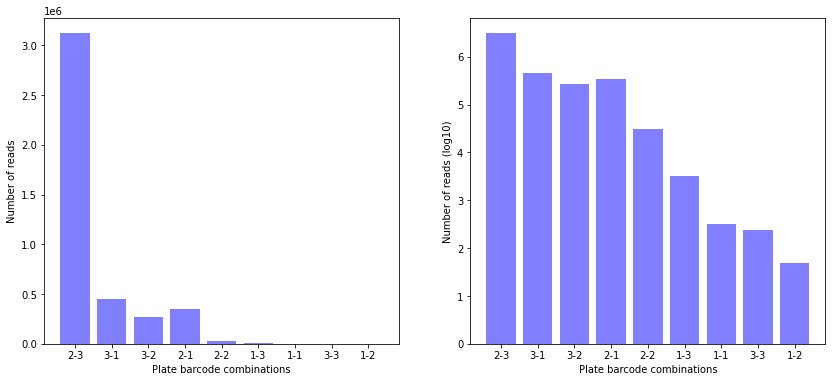

In [25]:
def plot_reads_per_plate(shared_index_list, index_for_dict, index_rev_dict):
    
    plate_read_counter = Counter()
    
    for read in shared_index_list:
        
        for_index = index_for_dict[read]
        rev_index = index_rev_dict[read]
        
        plate = for_index+'-'+rev_index
        
        plate_read_counter[plate] +=1
    
    plt.figure(figsize=(14,6))
    plt.subplot(121)
    plt.bar(range(len(plate_read_counter)), list(plate_read_counter.values()), align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), list(plate_read_counter.keys()))
    plt.xlabel('Plate barcode combinations')
    plt.ylabel('Number of reads')
    
    plt.subplot(122)
    plt.bar(range(len(plate_read_counter)), [np.log10(x) for x in plate_read_counter.values()], align='center', color = 'blue', alpha=0.5)
    plt.xticks(range(len(plate_read_counter)), list(plate_read_counter.keys()))
    plt.xlabel('Plate barcode combinations')
    plt.ylabel('Number of reads (log10)')
    
plot_reads_per_plate(plate_both, plate_index_found_for, plate_index_found_rev)

In [26]:
RC_pcr_amplicon_for = './amplicon_sequences/RC_pcr_for.fa'
RC_pcr_amplicon_rev = './amplicon_sequences/RC_pcr_rev.fa'

RC_for_indexes = range(1,18)

RC_rev_indexes = range(1,18)

print(RC_for_indexes)
print(RC_rev_indexes)


with open(RC_pcr_amplicon_for, 'w') as fasta_out:
    
    for index in RC_for_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = universal_seqs['plate_fivep_sticky']+index_seq+universal_seqs['RC_fivep_sticky']+'\n'
        fasta_out.write(amplicon_frag)
        
        
for_RC_index = './bowtie_indexes/'+experiment_name+'_for_RC'
for_RC_bowtie_index_call = 'bowtie-build -f -r -o 4 '+RC_pcr_amplicon_for+' '+for_RC_index
for_RC_indexing_log = subprocess.check_output(for_RC_bowtie_index_call, shell=True)
        
        
with open(RC_pcr_amplicon_rev, 'w') as fasta_out:
    
    for index in RC_rev_indexes:

        index_seq = indexes[str(index)]
        
        header = '>'+str(index)+'\n'
        fasta_out.write(header)
        
        amplicon_frag = reverse_complement(universal_seqs['plate_threep_sticky']) + index_seq
        amplicon_frag += reverse_complement(universal_seqs['RC_threep_sticky'])+'\n'
        fasta_out.write(amplicon_frag)    
    
rev_RC_index = './bowtie_indexes/'+experiment_name+'_rev_RC'
rev_RC_bowtie_index_call = 'bowtie-build -f -r -o 4 '+RC_pcr_amplicon_rev+' '+rev_RC_index
rev_RC_indexing_log = subprocess.check_output(rev_RC_bowtie_index_call, shell=True)
    

range(1, 18)
range(1, 18)


In [27]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 195 --trim5 28 --norc --chunkmbs 256 '
# adjusted for 50pb trimming

test_align_call += for_RC_index+' '
test_align_call += './temp/minlen299_1P.fastq '
test_align_call += './temp/RC_for_align.txt'

subprocess.check_output(test_align_call, shell = True)

b''

In [28]:
test_align_call = 'bowtie -t -v 3 -p 6 -k 1 --trim3 197 --trim5 26 --norc --chunkmbs 256 '
# adjusted for 50pb trimming

test_align_call += rev_RC_index+' '
test_align_call += './temp/minlen299_2P.fastq '
test_align_call += './temp/RC_rev_align.txt'

subprocess.check_output(test_align_call, shell = True)

b''

In [29]:
RC_align_for_output = './temp/RC_for_align.txt'
RC_align_rev_output = './temp/RC_rev_align.txt'


index_found_for_RC = {}
index_found_rev_RC = {}
# empty containers that will hold    read_name: index    data pairs for the forward and reverse reads that
# had valid alignments


with open(RC_align_for_output, 'r') as for_index_positives:
    for line in for_index_positives:
        # opens P1 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info, not the illumina annotations in the read 
        # name. See http://support.illumina.com/content/dam/illumina-support/help/BaseSpaceHelp_v2/Content/Vault/
        #           Informatics/Sequencing_Analysis/BS/swSEQ_mBS_FASTQFiles.htm
        # For info on illumina read name convention
        index_found_for_RC[read_name] = line[2]
        # add read P1 index to dict

#log_entry['for_index_pos'] = len(index_found_for.keys())
# log entry: number of reads with valid P1 index alignments

with open(RC_align_rev_output, 'r') as rev_index_positives:
    for line in rev_index_positives:
        # opens P2 index alignment pack file and loops through lines

        line = line.split('\t')
        # split line to extract data
        read_name = line[0].split(' ')[0]
        # Only keep the cluster coordinates and run associated info
        index_found_rev_RC[read_name] = line[2]
        # add read P2 index to dict

#log_entry['rev_index_pos'] = len(index_found_rev.keys())
# log entry: number of reads with valid P2 index alignments


both_indexes_RC = list(set(index_found_for_RC.keys()) & set(index_found_rev_RC.keys()))
#log_entry['both_index'] = len(both_indexes)
# Use the set data format to quickly id reads with valid alignments for both P1 and P2 indexes, and stores the
# taht number for the read pack in the log
print(len(both_indexes_RC))



4005416


In [30]:
valid_plates = plate_index_pair_list = [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3), (3,1), (3,2), (3,3)]

def plot_reads_in_plate(plate_both, RC_both, plate_index_found_for, plate_index_found_rev, index_found_for_RC, index_found_rev_RC, plate,
                       silent=True):
    
    plate_rows = sorted(set(index_found_for_RC.values()))
    plate_columns = sorted(set(index_found_rev_RC.values()))
    
    read_plate_RC_dict = {}
    grid_dict = {}
    
    for row in plate_rows:
        
        grid_dict[int(row)] = {}
        
        #print(row)
        
        for column in plate_columns:
            
            #print(type(column))
            
            grid_dict[int(row)][int(column)] = 0
            
    if silent == False:
        
        print(grid_dict)
    
    plate_and_rc_both = list((set(plate_both)&set(both_indexes_RC)))
    
    for read in plate_and_rc_both:
        
        for_index_plate = int(plate_index_found_for[read])
        rev_index_plate = int(plate_index_found_rev[read])
        
        #print(for_index_plate, rev_index_plate)
        
        #print(plate)
        #print(tuple((for_index_plate,rev_index_plate)))
        
        if tuple((int(for_index_plate), int(rev_index_plate))) == plate:
            
            #print('ok')
            
            for_index_RC = int(index_found_for_RC[read])
            rev_index_RC = int(index_found_rev_RC[read])
            
            #print(for_index_RC, rev_index_RC)
            #print(grid_dict[for_index_RC][rev_index_RC])
            
            grid_dict[for_index_RC][rev_index_RC] += 1
            
            read_plate_RC_dict[read] = [int(for_index_plate), int(rev_index_plate), for_index_RC, rev_index_RC]
            
            
            
    plate_df = pd.DataFrame.from_dict(grid_dict, orient='index')
    return plate_df, read_plate_RC_dict
            
            
#F_1 = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
#                                index_found_rev_RC, tuple((1,3)), silent = True)
#F_2 = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
#                                index_found_rev_RC, tuple((2,3)), silent = True)
#F_3 = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
#                                index_found_rev_RC, tuple((3,3)), silent = True)
#F_AKD = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
#                                index_found_rev_RC, tuple((2,2)), silent = True)


In [31]:
import seaborn as sns
from matplotlib.colors import LogNorm


In [57]:
F_1[0].loc[1][[1,2,3,4,5,6,7,8]]

1    657534
2    625969
3    571523
4    586049
5    582842
6    543674
7        57
8        65
Name: 1, dtype: int64

In [58]:
F_2[0].loc[2][[1,2,3,4,5,6,7,8]]

1    737338
2    743879
3    644554
4    755918
5    780932
6    705240
7    689964
8    736371
Name: 2, dtype: int64

In [59]:
F_3[0].loc[3][[1,2,3,4,5,6,7,8]]

1    620410
2    672529
3    544835
4    617566
5    583520
6    612154
7    671094
8    585362
Name: 3, dtype: int64

In [60]:
F_AKD[0].loc[[1,2,3,4,5,6]][1]

1    408922
2    140181
3    276333
4    405125
5    243480
6    265797
Name: 1, dtype: int64

Text(0.5, 1.0, 'Fragment 1')

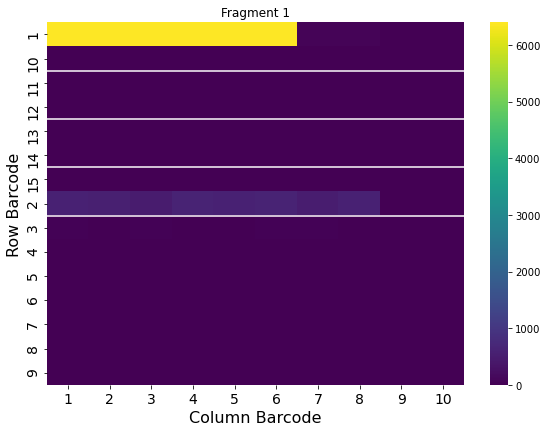

In [61]:
col_order = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(14/1.5, 10/1.5))


sns.heatmap(F_1[0][col_order], vmax=6400, cmap='viridis',)
plt.xlabel('Column Barcode', fontsize = 16)
plt.ylabel('Row Barcode', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.axhline(2, color='white')
plt.axhline(4, color='white')
plt.axhline(6, color='white')
plt.axhline(8, color='white')
plt.title('Fragment 1')

In [32]:
valid_plates

[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]

In [33]:
all_plate_index_dicts = []

for plate in valid_plates:
    
    mapping = plot_reads_in_plate(plate_both, both_indexes_RC, plate_index_found_for, plate_index_found_rev, index_found_for_RC, 
                                index_found_rev_RC, plate, silent=True)[1]
    
    all_plate_index_dicts.append(mapping)

In [34]:
sample_dataframe=pd.read_csv('./sample_datasheet.csv', index_col=0, sep=',')

In [36]:
os.mkdir('./demultiplexed_reads')

In [37]:
valid_plates

[(1, 1), (1, 2), (1, 3), (2, 1), (2, 2), (2, 3), (3, 1), (3, 2), (3, 3)]

In [ ]:
plate_RC_combi_to_dict = {}

out_fastq_path_dict_for_df = {}

out_fastq_path_dict_demult = {}

dir_path = './demultiplexed_reads/'


for sample in sample_dataframe.index:
    
    plate_for = sample_dataframe.loc[sample]['PE1_index']
    RC_for = sample_dataframe.loc[sample]['RC_for_index']
    RC_rev = sample_dataframe.loc[sample]['RC_rev_index']
    plate_rev = sample_dataframe.loc[sample]['PE2_index']
    
    plate_RC_combi_to_dict[sample] = [plate_for, plate_rev, RC_for, RC_rev]
    
    out_path = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)
    
    out_path_1 = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)+'_for'+'.fastq'
    out_path_2 = dir_path+str(sample)+'_indexes_'+str(plate_for)+'_'+str(plate_rev)+'_'+str(RC_for)+'_'+str(RC_rev)+'_rev'+'.fastq'
    
    out_fastq_path_dict_for_df[sample] = out_path
    
    out_fastq_path_dict_demult[tuple([plate_for, plate_rev, RC_for, RC_rev])] = out_path
    
    create_file_for = 'touch '+ out_path_1
    create_file_rev = 'touch '+ out_path_2
    
    subprocess.check_output(create_file_for, shell=True)
    subprocess.check_output(create_file_rev, shell=True)
    


for plate_dict in all_plate_index_dicts:
    
    print(len(plate_dict.keys()))

    for read in list(plate_dict.keys()):

        index_combi = plate_dict[read]

        if index_combi not in plate_RC_combi_to_dict.values():

            plate_dict.pop(read, None)
        
    print(len(plate_dict.keys()))



In [39]:
def split_reads_from_fastq(file, file_type, plate_mapping_list):
    
    to_write = 'none'
    read_name = 'none'
    
    
    with open(file, 'r') as source_fastq:
        
        for line in source_fastq:
            
            #print(read_name)
            #print(line)

            if line.startswith('@M') == True:
                
                if to_write == 'none':
                    
                    read_name = line.split(' ')[0].strip('@')
                    to_write = line

                else:
                    
                    for plate_read_dict in plate_mapping_list:
                        
                                                
                        if read_name in plate_read_dict.keys():

                            #print ('ok')

                            indexes = tuple(plate_read_dict[read_name])
                            
                            if file_type == 'forward':
                                
                                file_path = out_fastq_path_dict_demult[indexes]+'_for.fastq'
                                
                            elif file_type == 'reverse':
                                
                                file_path = out_fastq_path_dict_demult[indexes]+'_rev.fastq'

                            
                            
                            with open(file_path, 'a') as dest:
                                
                                   dest.write(to_write)

                            break





                    read_name = line.split(' ')[0].strip('@')

                    to_write = line
                

            else:

                to_write += line
                
split_reads_from_fastq('./temp/minlen299_1P.fastq', 'forward', all_plate_index_dicts)
split_reads_from_fastq('./temp/minlen299_2P.fastq', 'reverse', all_plate_index_dicts)

In [11]:
sample_dataframe['filepath'] = sample_dataframe.index.map(out_fastq_path_dict_for_df)


sample_dataframe.to_csv('./sample_datasheet_demultiplexed.csv', sep=',')

In [12]:
sample_dataframe = pd.read_csv('./sample_datasheet_demultiplexed.csv', sep=',', index_col = 0)
sample_dataframe.index.rename('Sample_ID', inplace=True)


In [17]:
before_merge_depth_dict = {}



def merge_reads(Sample_ID):
    
    filepath = sample_dataframe.loc[Sample_ID]['filepath']
    
    filepath_for = filepath+'_for.fastq'
    filepath_rev = filepath+'_rev.fastq'
    
    sample_read_count = 0
    
    with open(filepath_for, 'r') as source:
        
        for line in source:
            
            if line.startswith('@M'):
                
                sample_read_count += 1
                
    before_merge_depth_dict[Sample_ID] = sample_read_count
                
    if sample_read_count >= 1:
        
                
        filepath_out = './merged_reads/'+str(Sample_ID)+'.fasta'


        panda_seq_call = 'pandaseq -f '+filepath_for+' -r '+filepath_rev+ ' -L 550 -O 400 -k 4 -B -N -t 0.5 -T 6 -w '+ filepath_out

        subprocess.check_output(panda_seq_call, shell=True)
        
    return sample_read_count
    
    
merge_reads(16)

209603

In [18]:
for sample_ID in list(sample_dataframe.index):
    
    merge_reads(sample_ID)

In [19]:
after_merge_depth_dict = {}

def count_merged(Sample_ID):
    
    filepath = './merged_reads/'
    
    filepath_merged = str(Sample_ID)+'.fasta'
    
    filepath+=filepath_merged
    
    after_merge_depth = 0
    
    #if sample_dataframe.loc[Sample_ID]['demult_read_count'] >= 0:
    
    with open(filepath, 'r') as source:

        for line in source:

            if line.startswith('>'):

                after_merge_depth += 1

    after_merge_depth_dict[Sample_ID] = after_merge_depth
    
    return after_merge_depth
    
    
count_merged(0)    

81481

In [ ]:
for sample_ID in list(sample_dataframe.index):
    
    count_merged(sample_ID)
    
sample_dataframe['merged_read_count'] = pd.Series(after_merge_depth_dict)
# add read count info to the dataframe

sample_dataframe['merged_read_count'].head(35)

In [ ]:
sample_dataframe.merged_read_count.sum()

In [ ]:
# got 655575 reads out of pandaseq, looks nice

In [51]:
sample_dataframe = pd.read_csv('./sample_datasheet_demultiplexed.csv', sep=',', index_col = 0)
sample_dataframe.index.rename('Sample_ID', inplace=True)


In [52]:
sample_dataframe

,Locus,Type,Fragment,Timepoint,Position_DMS,PE1_index,RC_for_index,RC_rev_index,PE2_index,filepath
Sample_ID,,,,,,,,,,
8,FCY1,mat_a,1,FC4,1,2,5,12,3,./demultiplexed_reads/8_indexes_2_3_5_12
9,FCY1,mat_a,1,FC4,2,2,6,12,3,./demultiplexed_reads/9_indexes_2_3_6_12
10,FCY1,mat_a,1,FC4,3,2,7,12,3,./demultiplexed_reads/10_indexes_2_3_7_12
11,FCY1,mat_alpha,1,FC4,1,2,8,12,3,./demultiplexed_reads/11_indexes_2_3_8_12
12,FCY1,mat_alpha,1,FC4,2,2,9,12,3,./demultiplexed_reads/12_indexes_2_3_9_12
13,FCY1,mat_alpha,1,FC4,3,2,10,12,3,./demultiplexed_reads/13_indexes_2_3_10_12
14,FCY1,mat_a,2,FC4,1,2,5,13,3,./demultiplexed_reads/14_indexes_2_3_5_13
15,FCY1,mat_a,2,FC4,2,2,6,13,3,./demultiplexed_reads/15_indexes_2_3_6_13
16,FCY1,mat_a,2,FC4,3,2,7,13,3,./demultiplexed_reads/16_indexes_2_3_7_13


In [53]:
path = './merged_reads/26.fasta'

## Aggregate with vsearch

In [54]:
vsearch_trim_call = 'vsearch --fastx_filter ./merged_reads/23.fasta --fastq_stripleft 76 --fastq_stripright 76 --fastaout ./merged_reads/23_merged.fa'
    
print (vsearch_trim_call)

subprocess.check_output(vsearch_trim_call, shell=True)

vsearch --fastx_filter ./merged_reads/23.fasta --fastq_stripleft 76 --fastq_stripright 76 --fastaout ./merged_reads/23_merged.fa


b''

In [55]:
vsearch_aggregate_call = 'vsearch --derep_fulllength ./merged_reads/23_merged.fa --relabel seq --output ./merged_reads/23_agg.fa --sizeout'
print (vsearch_aggregate_call)
subprocess.check_output(vsearch_aggregate_call, shell=True)

vsearch --derep_fulllength ./merged_reads/23_merged.fa --relabel seq --output ./merged_reads/23_agg.fa --sizeout


b''

197787


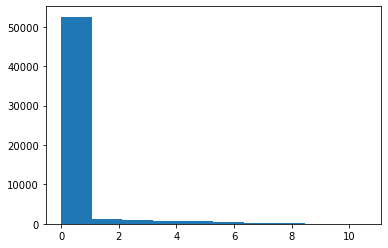

In [56]:
aggregated_reads = './merged_reads/23_aggregate.fa'

abundance_dict = {}

with open(aggregated_reads, 'r') as source:
    for line in source:
        if line.startswith('>')==True:
            seq_info = line.split(';')
            seq_id = seq_info[0]
            seq_count = int(seq_info[1].strip('size='))
            abundance_dict[seq_id] = seq_count
            
plt.hist([np.log2(x) for x in abundance_dict.values()])


print(sum(abundance_dict.values()))

{300: 23, 250: 46, 200: 89, 150: 185, 100: 356, 80: 473, 60: 676, 50: 802, 45: 894, 40: 974, 35: 1067, 30: 1168, 25: 1327, 20: 1573, 15: 1903, 10: 2449, 5: 3510, 2: 6845}


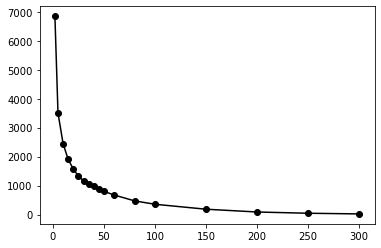

In [57]:
threshold_dict = {}

for n_read in [300, 250, 200, 150, 100, 80, 60, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 2]:
    over_t = 0
    for x in abundance_dict.values():
        if x >= n_read:
            over_t +=1
            
    threshold_dict[n_read] = over_t
        
print(threshold_dict)

plt.plot(list(threshold_dict.keys()), [threshold_dict[x] for x in threshold_dict.keys()], 'ko-')
            

In [58]:
65*64

4160

(array([ 7., 13., 15., 16., 16., 17., 17., 17., 17., 18.]),
 array([  23. ,  705.2, 1387.4, 2069.6, 2751.8, 3434. , 4116.2, 4798.4,
        5480.6, 6162.8, 6845. ]),
 [<matplotlib.patches.Polygon at 0x7f27b855d090>])

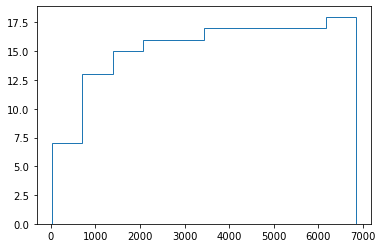

In [59]:
plt.hist(threshold_dict.values(), histtype='step', cumulative=True)

In [60]:
def trim_aggregate(Sample_ID):
       
    filepath = './merged_reads/'
    
    filepath_merged = filepath+str(Sample_ID)+'.fasta'
    
    trim_path = filepath + str(Sample_ID)+ '_trim.fasta'
    aggregate_path = filepath +str(Sample_ID)+ '_agg.fasta'
    
    vsearch_trim_call = 'vsearch --fastx_filter '+filepath_merged+' --fastq_stripleft 76 --fastq_stripright 76 --fastaout ' + trim_path
    subprocess.check_output(vsearch_trim_call, shell=True)
    
    vsearch_aggregate_call = 'vsearch --derep_fulllength '+ trim_path +' --relabel seq --output '+aggregate_path+' --sizeout'
    subprocess.check_output(vsearch_aggregate_call, shell=True)
    
    
trim_aggregate(23)

In [61]:
def check_aggregate_plot(Sample_ID):
    
    aggregated_reads = './merged_reads/'+str(Sample_ID)+'_agg.fasta'

    abundance_dict = {}

    
    
    with open(aggregated_reads, 'r') as source:
        for line in source:
            if line.startswith('>')==True:
                seq_info = line.split(';')
                seq_id = seq_info[0]
                seq_count = int(seq_info[1].strip('size='))
                abundance_dict[seq_id] = seq_count
                
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)

    plt.hist([np.log2(x) for x in abundance_dict.values()], density=True)
    plt.xlabel('log2 read abundance')
    plt.ylabel('density')

    
    plt.subplot(1,2,2)

    threshold_dict = {}

    for n_read in [300, 250, 200, 150, 100, 80, 60, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 2]:
        over_t = 0
        for x in abundance_dict.values():
            if x >= n_read:
                over_t +=1

        threshold_dict[n_read] = over_t

    #print(threshold_dict)

    plt.plot(list(threshold_dict.keys()), [threshold_dict[x] for x in threshold_dict.keys()], 'ko-')
    plt.xlabel('threshold')
    plt.ylabel('n sequences above threshold')
    
    
    plt.tight_layout()
    
    fig_path = './merged_reads/'+str(Sample_ID)+'_plot.png'
    plt.savefig(fig_path, format='png', dpi=200)
    plt.close()

    
    return

check_aggregate_plot(23)

In [62]:
for sample_ID in list(sample_dataframe.index):
    
    trim_aggregate(sample_ID)
    check_aggregate_plot(sample_ID)

In [63]:
path_to_amplicons = './amplicon_sequences/FCY1_frags.fa'

amplicon_info_dict = get_dict_of_seq(path_to_amplicons)

amplicon_length_dict = {}

amplicon_dict = {}

for amplicon in amplicon_info_dict:
    
    amplicon_name = amplicon.split('|')[0]

    amplicon_dict[amplicon_name] = amplicon_info_dict[amplicon]
    
    amplicon_fasta_path = './amplicon_sequences/'+amplicon_name+'.fasta'
    
    with open(amplicon_fasta_path, 'w') as dest:
        
        seq_ID = '>'+amplicon_name+'\n'
        seq = amplicon_dict[amplicon_name]+'\n'
        
        dest.write(seq_ID)
        dest.write(seq)
    

print (amplicon_info_dict.keys())
print (amplicon_dict)



dict_keys(['FCY1_frag_1', 'FCY1_frag_2', 'FCY1_frag_3'])
{'FCY1_frag_1': 'CAGCTTAAAGAGTTAAAAATTTCATAGCTAATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAG', 'FCY1_frag_2': 'GGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAGGTAAGGTCTATAAGGACACCACCTTGTACACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGG', 'FCY1_frag_3': 'CACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAATGAAGCACGCAGCACGCTGTATTT'}


In [65]:
#os.mkdir('amplicon_align')

In [66]:
def needle_align_on_ref(Sample_ID):
    
    frag = 'F'+str(sample_dataframe.loc[Sample_ID]['Fragment'])
    
    
    if frag == 'F1':
        
        ref_orf = 'FCY1_frag_1'
    
    elif frag == 'F2':
        
        ref_orf = 'FCY1_frag_2'
        
    elif frag == 'F3':
        
        ref_orf = 'FCY1_frag_3'
               
    
    ref_seq = amplicon_dict[ref_orf]
    
    ref_fasta_path = './amplicon_sequences/'+ref_orf+'.fasta '
    
    
    filepath = './merged_reads/'+str(Sample_ID)+'_agg.fasta'
    
    needle_out = './amplicon_align/'+str(Sample_ID)+'_agg.needle'
    
    needle_call = 'needle -auto -gapopen 50 -asequence '+ ref_fasta_path
    
    needle_call += '-bsequence '+ filepath +' -aformat3 markx10 -outfile '+needle_out
    
       
    print(needle_call)
    
    subprocess.check_output(needle_call, shell = True)
    
    #cleanup_call = 'rm ' + orf + '.*'
    
    #subprocess.check_output(cleanup_call, shell = True)
        
   
    return

needle_align_on_ref(23)



needle -auto -gapopen 50 -asequence ./amplicon_sequences/FCY1_frag_3.fasta -bsequence ./merged_reads/23_agg.fasta -aformat3 markx10 -outfile ./amplicon_align/23_agg.needle


In [67]:
for sample_ID in list(sample_dataframe.index):
    
    needle_align_on_ref(sample_ID)

needle -auto -gapopen 50 -asequence ./amplicon_sequences/FCY1_frag_1.fasta -bsequence ./merged_reads/8_agg.fasta -aformat3 markx10 -outfile ./amplicon_align/8_agg.needle
needle -auto -gapopen 50 -asequence ./amplicon_sequences/FCY1_frag_1.fasta -bsequence ./merged_reads/9_agg.fasta -aformat3 markx10 -outfile ./amplicon_align/9_agg.needle
needle -auto -gapopen 50 -asequence ./amplicon_sequences/FCY1_frag_1.fasta -bsequence ./merged_reads/10_agg.fasta -aformat3 markx10 -outfile ./amplicon_align/10_agg.needle
needle -auto -gapopen 50 -asequence ./amplicon_sequences/FCY1_frag_1.fasta -bsequence ./merged_reads/11_agg.fasta -aformat3 markx10 -outfile ./amplicon_align/11_agg.needle
needle -auto -gapopen 50 -asequence ./amplicon_sequences/FCY1_frag_1.fasta -bsequence ./merged_reads/12_agg.fasta -aformat3 markx10 -outfile ./amplicon_align/12_agg.needle
needle -auto -gapopen 50 -asequence ./amplicon_sequences/FCY1_frag_1.fasta -bsequence ./merged_reads/13_agg.fasta -aformat3 markx10 -outfile ./a

In [68]:
def parse_needle_output(path):
    
    n_aligns = 0
    
    align_seqs_dict = {}
    
            
    needle_align_path = './amplicon_align/'+path+'.needle'
        
    with open(needle_align_path, 'r') as source:

        current_align = ''

        current_qseq = ''

        current_sseq = ''

        qseq_done = 0
        


        for line in source:

            if line.startswith('>>>') == True:

                n_aligns +=1

                align_name = line.strip('>>>')
                #print (line)

                if n_aligns != 1:

                    align_seqs_dict[current_align] = [current_qseq, current_sseq]

                    current_align = align_name

                    current_qseq = ''

                    current_sseq = ''

                    qseq_done = 0



                else:

                    current_align = align_name

 
            elif line.startswith(';') == False and line.startswith('>') == False and line.startswith('\n') == False and line.startswith('#') == False:

                if qseq_done == 1:

                    current_sseq += line.strip('\n')

                else:

                    current_qseq += line.strip('\n')



            elif line.startswith('#--') == True:

                align_seqs_dict[align_name] = [current_qseq, current_sseq]

            else:

                if qseq_done == 0 and current_qseq != '':

                    qseq_done =1            
                
                    
    return align_seqs_dict, n_aligns
                    
                    
parse_needle_output('23_agg')
                    
                    
                
                  

({'FCY1_frag_3, 244 nt vs seq1;size=1523, 221 nt\n': ['CACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAATGAAGCACGCAGCACGCTGTATTT',
   '-----------CACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAATGAAGCACGCAG------------'],
  'FCY1_frag_3, 244 nt vs seq2;size=1103, 221 nt\n': ['CACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAATGAAGCACGCAGCACGCTGTATTT',
   '-----------CACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTGGGTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCG

In [69]:
align_count_dict = {}

mut_count_dict = {}

def find_mutations(path, fragment):
    
    allele_dict = {}
    
    if fragment == 'F1':
        
        ref_orf = 'FCY1_frag_1'
    
    elif fragment == 'F2':
        
        ref_orf = 'FCY1_frag_2'
        
    elif fragment == 'F3':
        
        ref_orf = 'FCY1_frag_3'

    

    align_dict, align_count = parse_needle_output(path)

    
    for entry in list(align_dict.keys()):

        read_var_list = []

        query_seq = align_dict[entry][1]
        # aligned prot sequence of the strain

        align_ref = align_dict[entry][0]
        # aligned prot sequence of the reference

        gap_adjust = 0
        # value used to adjust the protein sequence index for the presence of insertions in the strain sequence vs the 
        # reference strain

        backtrack_adjust = 0

        temp_var = None
        # temporary variable to hold the sequence of an insertion or deletion as a string. When the gap ends, annotation 
        # will be added to strain_var_list

        indel_start = 0
        # position start of the indel annotation in the reference sequence, with adjustment for gap presence

        ref_seq_no_gaps = align_ref.replace('-','')

        align_start = (amplicon_dict[ref_orf].index(ref_seq_no_gaps))+1

        query_seq_no_gaps = len(query_seq.replace('-',''))

        for nt in range(0, len(align_ref)):
            # iterates through the entire alignment of the strain prot sequence

            if query_seq[nt] == '-':
                # detect a deletion variant

                # logic for indel detection/annotation:
                #
                # suppose we have this alignment  
                #
                # 1 2 3 4 5 6 7 8 9
                # A T - - A A A T G    strain variant: del gaps are indexed because the aa index is based on reference
                # A T K P A - - T G
                # 1 2 3 4 5     6 7    reference: insert gaps not indexed because aa positions do exist in reference
                #
                # following this logic, every time an insertion is detected and annotated, the gap_adjust value is 
                # incremented by the length of the gap and used to adjust the variant mapping to make it match the 
                # reference index values. The indel aa postion is the first residue detected as part of the indel


                if indel_start == 0:
                    # checks if the character is the start or the continuation of a gap in the alignment

                    temp_var = 'del'+ align_ref[nt]
                    indel_start = (nt+1-gap_adjust)
                    # if it is, starts a new annotation entry with a start position compensated for previous insertions
                    # (if any)

                    backtrack_adjust += 1

                else:

                    temp_var += align_ref[nt]
                    # if it is not, adds the following aa to the deletion annotation

                    backtrack_adjust += 1


            elif align_ref[nt] == '-':
                # detects an insertion variant

                if indel_start == 0:
                    # checks if the character is the start or the continuation of a gap in the alignment

                    temp_var = 'ins'+ query_seq[nt]

                    indel_start = (nt+1-gap_adjust)
                    # if it is, starts a new annotation entry with a start position compensated for previous insertions
                    # (if any)

                    gap_adjust += 1
                    # increments the gap adjust for the this added aa in the strain sequence                   


                else:

                    temp_var += query_seq[nt]
                    # if it is not, adds the following aa to the insertion annotation

                    gap_adjust += 1
                    # increments the gap adjust for the this added aa in the strain sequence


            elif query_seq[nt] != align_ref[nt]:
                # detects a mismatch between the strain sequence and the reference


                variant = align_ref[nt]+'|'+str((nt+1-gap_adjust))+'|'+query_seq[nt]
                read_var_list.append(variant)
                # creates an annotation for the strain-reference aa mismatch and appends it to the list of 
                # annotations

            else:

                 if indel_start != 0:
                    # detects if there is currently an open gap entry. If there is, then the detected mismatch means 
                    # that it has now concluded

                    read_var_list.append(str((indel_start))+temp_var)
                    temp_var = None
                    indel_start = 0
                    # adds the indel annotation to the strain variant list and resets temporary variables for the next 
                    # indel entry


        if query_seq_no_gaps >=  len(ref_seq_no_gaps)*0.8 and len(read_var_list)<25:            
            allele_dict[entry] = read_var_list, align_start
                           
    return allele_dict

# looks good for all alleles tested      


In [71]:
pool_1_a_muts = find_mutations('8_agg', 'F1')

In [72]:
def get_n_align(allele_dict):
    
    n_align = 0
    
    for seq in list(allele_dict.keys()):
        
        var_info = seq.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
        
        n_align += var_count
        
    
    return n_align

get_n_align(pool_1_a_muts)

178570

In [73]:
list_offset = []

for x in pool_1_a_muts.values():
    #print(x)
    list_offset.append(x[1])
    
print(set(list_offset))

{1}


In [74]:
len(pool_1_a_muts)

55836

In [76]:
list_insert_counter = Counter()

for x in pool_1_a_muts.values():
    for y in x[0]:
        if 'del' in y:
            list_insert_counter[y]+=1
    
print(sum(list_insert_counter.values()))
print(list_insert_counter)

60678
Counter({'1delCAGCTTAAAGA': 47945, '1delCAGCTTAAAGAG': 5989, '65delA': 1046, '1delCAGCTTAAAG': 931, '1delCAGCTTAAAGAGT': 700, '194delA': 509, '55delA': 143, '102delG': 136, '99delT': 111, '1delCAGCTTAAAGAGTT': 110, '79delA': 94, '59delG': 85, '148delA': 79, '192delC': 72, '105delT': 72, '124delC': 71, '166delT': 68, '84delT': 64, '1delCAGCTTAAAGAGTTA': 64, '63delC': 63, '142delA': 61, '231delT': 61, '113delA': 58, '163delG': 55, '159delT': 55, '121delG': 55, '109delA': 46, '190delT': 43, '175delG': 43, '50delC': 41, '210delT': 40, '75delG': 40, '145delA': 40, '111delG': 38, '171delT': 36, '181delA': 36, '164delT': 36, '118delG': 34, '147delC': 33, '120delT': 32, '217delG': 31, '133delG': 31, '80delT': 29, '169delG': 29, '198delG': 28, '58delT': 28, '51delT': 27, '187delA': 27, '177delT': 26, '122delT': 26, '30delA': 26, '109delAAGG': 25, '201delT': 25, '91delG': 25, '163delGT': 24, '161delC': 24, '157delG': 24, '173delG': 23, '165delC': 23, '178delCA': 22, '82delG': 21, '43delG':

In [77]:
list_insert_counter = Counter()

for x in list(pool_1_a_muts.keys())[0:10]:
    print(x, pool_1_a_muts[x])
    


FCY1_frag_1, 256 nt vs seq1;size=707, 233 nt
 (['1delCAGCTTAAAGA'], 1)
FCY1_frag_1, 256 nt vs seq2;size=562, 233 nt
 (['1delCAGCTTAAAGA', 'G|103|T', 'T|105|G'], 1)
FCY1_frag_1, 256 nt vs seq3;size=432, 233 nt
 (['1delCAGCTTAAAGA', 'G|170|A'], 1)
FCY1_frag_1, 256 nt vs seq4;size=305, 233 nt
 (['1delCAGCTTAAAGA', 'A|142|G', 'T|143|G', 'C|144|G'], 1)
FCY1_frag_1, 256 nt vs seq5;size=298, 233 nt
 (['1delCAGCTTAAAGA', 'G|97|C', 'T|99|C'], 1)
FCY1_frag_1, 256 nt vs seq6;size=276, 233 nt
 (['1delCAGCTTAAAGA', 'G|176|T', 'T|177|G'], 1)
FCY1_frag_1, 256 nt vs seq7;size=258, 233 nt
 (['1delCAGCTTAAAGA', 'G|220|A', 'A|221|G', 'A|222|G'], 1)
FCY1_frag_1, 256 nt vs seq8;size=251, 233 nt
 (['1delCAGCTTAAAGA', 'T|139|C', 'T|140|C'], 1)
FCY1_frag_1, 256 nt vs seq9;size=249, 233 nt
 (['1delCAGCTTAAAGA', 'G|76|C', 'A|77|C', 'C|78|G'], 1)
FCY1_frag_1, 256 nt vs seq10;size=235, 233 nt
 (['1delCAGCTTAAAGA', 'G|217|C', 'G|218|T', 'C|219|G'], 1)


In [78]:
amplicon_dict

{'FCY1_frag_1': 'CAGCTTAAAGAGTTAAAAATTTCATAGCTAATGGTTACCGGTGGTATGGCTTCTAAATGGGACCAAAAAGGTATGGACATTGCTTACGAAGAAGCTGCTTTGGGTTACAAGGAAGGTGGTGTTCCAATCGGTGGTTGTTTGATCAACAACAAGGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAG',
 'FCY1_frag_2': 'GGATGGTTCCGTCTTAGGTAGAGGTCACAACATGAGATTCCAAAAGGGTTCTGCCACTCTACATGGCGAAATCTCTACTTTGGAAAACTGTGGTAGATTGGAAGGTAAGGTCTATAAGGACACCACCTTGTACACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGG',
 'FCY1_frag_3': 'CACTACTTTGTCACCATGCGACATGTGTACTGGTGCCATTATTATGTACGGTATCCCAAGATGTGTCGTCGGTGAAAATGTTAACTTCAAGTCCAAGGGTGAAAAGTACTTGCAAACCAGAGGTCACGAAGTTGTTGTCGTTGATGACGAAAGATGTAAGAAGATCATGAAGCAATTTATTGATGAACGTCCACAAGACTGGTTCGAAGATATTGGTGAATGAAGCACGCAGCACGCTGTATTT'}

In [79]:
amplicon_dict['FCY1_frag_1'][33]

'G'

In [80]:


def get_variant_count_1(mutation_set, ref_seq, frag_start, codon_start, n_aa):
    
    variant_abundance_dict ={}
    
    variants = list(mutation_set.keys())
    
    codon_groups = {}
    
    codon = 1
    
    wt_count =0
    valid_seq=0
    
    for nt in range(0, n_aa*3):
        pos = nt+34
        
        if nt % 3 == 0:
            codon += 1
            
        codon_groups[pos] = codon
        
        variant_abundance_dict[codon] = {}       
        
    wt_codons = {}
        
    ref = amplicon_dict[ref_seq]
    
    for aa in range(0, n_aa):
        offset = 33
        
        start = offset+(aa*3)
        
        wt_codon=ref[start:(start+3)]
        
        wt_codons[(aa+codon_start)] = wt_codon
        
        variant_abundance_dict[aa+codon_start][wt_codon]=np.nan 
        
        
    
    #print(variant_abundance_dict)
    
    #print(codon_groups)
    #print(wt_count)
    #print(wt_codons)
    #print(variant_abundance_dict)
           
    
    for variant in variants:
        
        var_info = variant.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
               
        mut_list = mutation_set[variant][0]
        
        filtered_list = []
        
        if var_count>=20:
            #print(mut_list)
        
            for mutation in mut_list:

                if 'del' in mutation:
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    
                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    
                else:
                    #print(mut_list)
                    mut_nt_list = []
                    
                    out_list = []
                    
                    for mutation in mut_list:
                        
                        mut_pos = int(mutation.split('|')[1])
                        
                        if mut_pos >=34 and mut_pos <= 231:
                        
                            mut_nt_list.append(codon_groups[mut_pos])
                            
                        else:
                            out_list.append(mut_pos)
                        
                    if len(set(mut_nt_list)) == 1:
                        valid_seq+=var_count
                        
                        codon = int(list(set(mut_nt_list))[0])
                        
                        wt_seq = wt_codons[codon]
                                                                      
                        new_seq = [x for x in wt_seq]
                        
                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            
                            codon_pos = (mut_pos-1)%3
                            
                            new_seq[codon_pos] = mutation
                            
                        new_codon = ''.join(new_seq)
                            
                        #print(wt_seq, mut_list, new_codon)
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            #print(codon, wt_seq ,new_codon, variant_abundance_dict[codon][new_codon], var_count, mut_list, var_info)

                            variant_abundance_dict[codon][new_codon]+=var_count
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            
  
                        
                    elif len(set(mut_nt_list)) == 0 and len(out_list)>=1:
                        #print(mut_nt_list, out_list)
                        wt_count+=var_count
                    
                    
        elif var_count < 20:

            for mutation in mut_list:

                if 'del' in mutation:
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])

                    if mut_pos == 1:
                        mut_list.remove(mutation)
                  
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):

                if len(mut_list) ==0:
                    wt_count += var_count

                else:
                    #print(mut_list)
                    mut_nt_list = []

                    out_list = []

                    for mutation in mut_list:

                        mut_pos = int(mutation.split('|')[1])

                        if mut_pos >=34 and mut_pos <= 231:

                            mut_nt_list.append(codon_groups[mut_pos])

                        else:
                            out_list.append(mut_pos)

                    if len(set(mut_nt_list)) == 1:
                        #print(mut_list, var_count)
                        valid_seq+=var_count

                        codon = int(list(set(mut_nt_list))[0])

                        wt_seq = wt_codons[codon]

                        new_seq = [x for x in wt_seq]

                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]

                            codon_pos = (mut_pos-1)%3

                            new_seq[codon_pos] = mutation

                        new_codon = ''.join(new_seq)

                        #print(wt_seq, mut_list, new_codon)
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            #print(codon, wt_seq ,new_codon, variant_abundance_dict[codon][new_codon], var_count, mut_list, var_info)

                            variant_abundance_dict[codon][new_codon]+=var_count
                            
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                
                        
            #print(var_info, mut_list)
    
    

    #print(valid_seq)
    #print(wt_count)
                    
    return variant_abundance_dict, wt_count

frag1_dict = get_variant_count_1(pool_1_a_muts, 'FCY1_frag_1', 34, 2,66)
    

In [81]:
frag1_dict[1]

886

In [82]:


def get_variant_count_2(mutation_set, ref_seq, frag_start, codon_start, n_aa):
    
    variant_abundance_dict ={}
    
    variants = list(mutation_set.keys())
    
    codon_groups = {}
    
    
    codon = 48
    
    wt_count =0
    valid_seq=0
    
    for nt in range(0, n_aa*3):
        pos = nt+23
        
        if nt % 3 == 0:
            codon += 1
            
        codon_groups[pos] = codon
        
        variant_abundance_dict[codon] = {}     
        
    #print(codon_groups)

        
    wt_codons = {}
        
    ref = amplicon_dict[ref_seq]
    
    for aa in range(0, n_aa):
        offset = 22
        
        start = offset+(aa*3)
        
        wt_codon=ref[start:(start+3)]
        
        wt_codons[(aa+codon_start)] = wt_codon
        
        variant_abundance_dict[aa+codon_start][wt_codon]=np.nan 
        
        
    
    #print(variant_abundance_dict)
    
    #print(codon_groups)
    #print(wt_count)
    #print(wt_codons)
    #print(variant_abundance_dict)
           
    
    for variant in variants:
        
        var_info = variant.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
               
        mut_list = mutation_set[variant][0]
        
        filtered_list = []
        
        if var_count>=20:
            #print(mut_list)
        
            for mutation in mut_list:

                if 'del' in mutation:
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    
                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    
                else:
                    mut_nt_list = []
                    
                    out_list = []
                    
                    for mutation in mut_list:
                        
                        mut_pos = int(mutation.split('|')[1])
                        
                        if mut_pos >=23 and mut_pos <= 208:
                        
                            mut_nt_list.append(codon_groups[mut_pos])
                            
                        else:
                            out_list.append(mut_pos)
                        
                    #print(mut_list, mut_nt_list)

                    
                    if len(set(mut_nt_list)) == 1:
                        valid_seq+=var_count
                        
                        codon = int(list(set(mut_nt_list))[0])
                        
                        wt_seq = wt_codons[codon]
                                                                      
                        new_seq = [x for x in wt_seq]
                        
                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            
                            codon_pos = (mut_pos-2)%3
                            
                            new_seq[codon_pos] = mutation
                            
                        new_codon = ''.join(new_seq)
                            
                        #print(wt_seq, mut_list, new_codon)
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            #print(codon, wt_seq ,new_codon, variant_abundance_dict[codon][new_codon], var_count, mut_list, var_info)

                            variant_abundance_dict[codon][new_codon]+=var_count
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
  
                        
                    elif len(set(mut_nt_list)) == 0 and len(out_list)>=1:
                        #print(mut_nt_list, out_list)
                        wt_count+=var_count
                    
        #elif len(mut_list) >3:
            #print(mut_list, var_info)
                    
                    
        elif var_count < 20:

            for mutation in mut_list:

                if 'del' in mutation:
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])

                    if mut_pos == 1:
                        mut_list.remove(mutation)
                  
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):

                if len(mut_list) ==0:
                    wt_count += var_count

                else:
                    #print(mut_list)
                    mut_nt_list = []

                    out_list = []

                    for mutation in mut_list:

                        mut_pos = int(mutation.split('|')[1])

                        if mut_pos >=23 and mut_pos <= 208:

                            mut_nt_list.append(codon_groups[mut_pos])

                        else:
                            out_list.append(mut_pos)

                    if len(set(mut_nt_list)) == 1:
                        #print(mut_list, var_count)
                        valid_seq+=var_count

                        codon = int(list(set(mut_nt_list))[0])

                        wt_seq = wt_codons[codon]

                        new_seq = [x for x in wt_seq]

                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]

                            codon_pos = (mut_pos-2)%3

                            new_seq[codon_pos] = mutation

                        new_codon = ''.join(new_seq)

                        #print(wt_seq, mut_list, new_codon)
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            #print(codon, wt_seq ,new_codon, variant_abundance_dict[codon][new_codon], var_count, mut_list, var_info)

                            variant_abundance_dict[codon][new_codon]+=var_count
                            
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                
                        
            #print(var_info, mut_list)
    
    

    #print(valid_seq)
    #print(wt_count)
                    
    return variant_abundance_dict, wt_count

    

In [83]:
#frag2_dict = get_variant_count_2(pool_1_muts, 'FCY1_frag_2', 22, 49,62)


In [84]:


def get_variant_count_3(mutation_set, ref_seq, frag_start, codon_start, n_aa):
    
    variant_abundance_dict ={}
    
    variants = list(mutation_set.keys())
    
    codon_groups = {}
    
    codon = 92
    
    wt_count =0
    valid_seq=0
    
    for nt in range(0, n_aa*3):
        pos = nt+23
        
        if nt % 3 == 0:
            codon += 1
            
        codon_groups[pos] = codon
        
        variant_abundance_dict[codon] = {}       
        
    wt_codons = {}
        
    ref = amplicon_dict[ref_seq]
    
    for aa in range(0, n_aa):
        offset = 22
        
        start = offset+(aa*3)
        
        wt_codon=ref[start:(start+3)]
        
        wt_codons[(aa+codon_start)] = wt_codon
        
        variant_abundance_dict[aa+codon_start][wt_codon]=np.nan 
        
        
    
    #print(variant_abundance_dict)
    
    #print(codon_groups)
    #print(wt_count)
    #print(wt_codons)
    #print(variant_abundance_dict)
           
    
    for variant in variants:
        
        var_info = variant.split(',')
        var_count =int(var_info[1].split(';')[1].strip('size='))
               
        mut_list = mutation_set[variant][0]
        
        filtered_list = []
        
        if var_count>=20:
            #print(mut_list)
        
            for mutation in mut_list:

                if 'del' in mutation:
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])
                    
                    if mut_pos == 1:
                        mut_list.remove(mutation)
                        
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):
                
                if len(mut_list) ==0:
                    wt_count += var_count
                    
                else:
                    #print(mut_list)
                    mut_nt_list = []
                    
                    out_list = []
                    
                    for mutation in mut_list:
                        
                        mut_pos = int(mutation.split('|')[1])
                        
                        if mut_pos >=23 and mut_pos <= 220:
                        
                            mut_nt_list.append(codon_groups[mut_pos])
                            
                        else:
                            out_list.append(mut_pos)
                        
                    if len(set(mut_nt_list)) == 1:
                        valid_seq+=var_count
                        
                        codon = int(list(set(mut_nt_list))[0])
                        
                        wt_seq = wt_codons[codon]
                                                                      
                        new_seq = [x for x in wt_seq]
                        
                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]
                            
                            codon_pos = (mut_pos-2)%3
                            
                            new_seq[codon_pos] = mutation
                            
                        new_codon = ''.join(new_seq)
                            
                        #print(wt_seq, mut_list, new_codon)
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            #print(codon, wt_seq ,new_codon, variant_abundance_dict[codon][new_codon], var_count, mut_list, var_info)

                            variant_abundance_dict[codon][new_codon]+=var_count
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                            
  
                        
                    elif len(set(mut_nt_list)) == 0 and len(out_list)>=1:
                        #print(mut_nt_list, out_list)
                        wt_count+=var_count
                    
        #elif len(mut_list) >3:
            #print(mut_list, var_info)
                    
                    
        elif var_count < 20:

            for mutation in mut_list:

                if 'del' in mutation:
                    mut_info = mutation.split('del')
                    mut_pos = int(mut_info[0])

                    if mut_pos == 1:
                        mut_list.remove(mutation)
                  
            if len(mut_list) <=3 and 'ins' not in str(mut_list) and 'del' not in str(mut_list):

                if len(mut_list) ==0:
                    wt_count += var_count

                else:
                    #print(mut_list)
                    mut_nt_list = []

                    out_list = []

                    for mutation in mut_list:

                        mut_pos = int(mutation.split('|')[1])

                        if mut_pos >=23 and mut_pos <= 220:
                            #adjusted to 220

                            mut_nt_list.append(codon_groups[mut_pos])

                        else:
                            out_list.append(mut_pos)

                    if len(set(mut_nt_list)) == 1:
                        #print(mut_list, var_count)
                        valid_seq+=var_count

                        codon = int(list(set(mut_nt_list))[0])

                        wt_seq = wt_codons[codon]

                        new_seq = [x for x in wt_seq]

                        for mutation in mut_list:
                            mut_pos = int(mutation.split('|')[1])
                            mutation = mutation.split('|')[2]

                            codon_pos = (mut_pos-2)%3

                            new_seq[codon_pos] = mutation

                        new_codon = ''.join(new_seq)

                        #print(wt_seq, mut_list, new_codon)
                        
                        if new_codon in list(variant_abundance_dict[codon].keys()):
                            #print(codon, wt_seq ,new_codon, variant_abundance_dict[codon][new_codon], var_count, mut_list, var_info)

                            variant_abundance_dict[codon][new_codon]+=var_count
                            
                            
                        else:
                            variant_abundance_dict[codon][new_codon]=var_count
                
                        
            #print(var_info, mut_list)
    
    

    #print(valid_seq)
    #print(wt_count)
                    
    return variant_abundance_dict, wt_count

#frag3_dict = get_variant_count_3(pool_3_muts, 'FCY1_frag_3', 22, 93,66)
    

In [87]:
def get_timepoint_fraction_df(Sample_ID):
    frag = 'F' + str(sample_dataframe.loc[Sample_ID]['Fragment'])
    
    align_path  = str(Sample_ID)+'_agg'
    
    allele_dict=find_mutations(align_path, frag)
    
    if frag =='F1':
        mut_dict, wt_count = get_variant_count_1(allele_dict, 'FCY1_frag_1', 34, 2,66)
        
    if frag =='F2':
        mut_dict, wt_count = get_variant_count_2(allele_dict, 'FCY1_frag_2', 22, 49,62)
        
    if frag =='F3':
        mut_dict, wt_count = get_variant_count_3(allele_dict, 'FCY1_frag_3', 22, 93,66)
        
        
        
    
    variant_df = pd.DataFrame(mut_dict)
    
    array_size=len(variant_df.to_numpy().flatten())
    
    
    
    
    read_total = variant_df.sum().sum()+wt_count+array_size
    print(Sample_ID, read_total, array_size, wt_count, wt_count/read_total)
    
    variant_df_no_NaN = variant_df.fillna(0)
    
    variant_df_no_NaN = variant_df_no_NaN + 1
    
    #wt_fraction=wt_count/read_total
    
    read_fraction_df = variant_df_no_NaN/(read_total)
    print(read_total, 1/read_total)
    
    read_fraction_df.rename_axis(read_total, inplace=True)
    
    df_out_path='./read_abundances/'+str(Sample_ID)+'_read_frac.csv'
    
    read_fraction_df.to_csv(df_out_path, sep=',')
    

    
    return read_fraction_df, variant_df
    
print(get_timepoint_fraction_df(23)[0].head(64))

23 138124.0 4224 2073 0.015008253453418668
138124.0 7.239871419883583e-06
               93        94        95        96        97        98   \
138124.0                                                               
ATG       0.000007  0.002295  0.000007  0.000652  0.000007  0.000051   
ATT       0.000087  0.000224  0.000007  0.000275  0.000007  0.000007   
AAT       0.000014  0.001195  0.000051  0.000174  0.000507  0.001397   
ATA       0.000014  0.000022  0.000014  0.000138  0.000007  0.000007   
ACG       0.000014  0.000782  0.000007  0.000159  0.000007  0.000862   
...            ...       ...       ...       ...       ...       ...   
TGC       0.000007  0.000043  0.000007  0.001166  0.000029  0.000014   
AGG       0.000007  0.000036  0.001665  0.000145  0.000311  0.000014   
GAG       0.000007  0.000014  0.000101  0.000608  0.001260  0.001397   
TAG       0.000007  0.000007  0.000681  0.000601  0.001332  0.000239   
AAG       0.000007  0.000007  0.000391  0.000152  0.000673  0.

In [88]:
pd.set_option('display.max_rows', 500)

In [89]:
1/604809

1.653414549055983e-06

8 126811.0 4224 886 0.006986775595177075
126811.0 7.885751236091505e-06


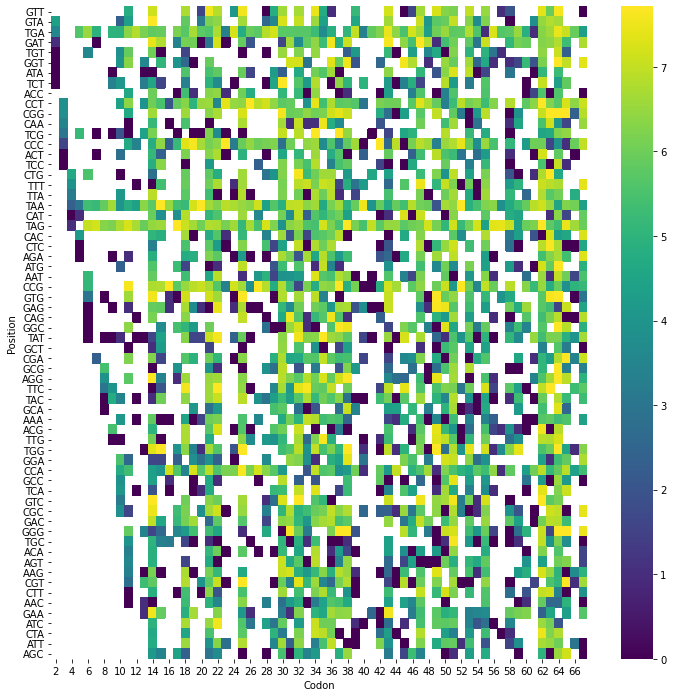

9 72827.0 4224 471 0.006467381602976918
72827.0 1.3731171131585813e-05


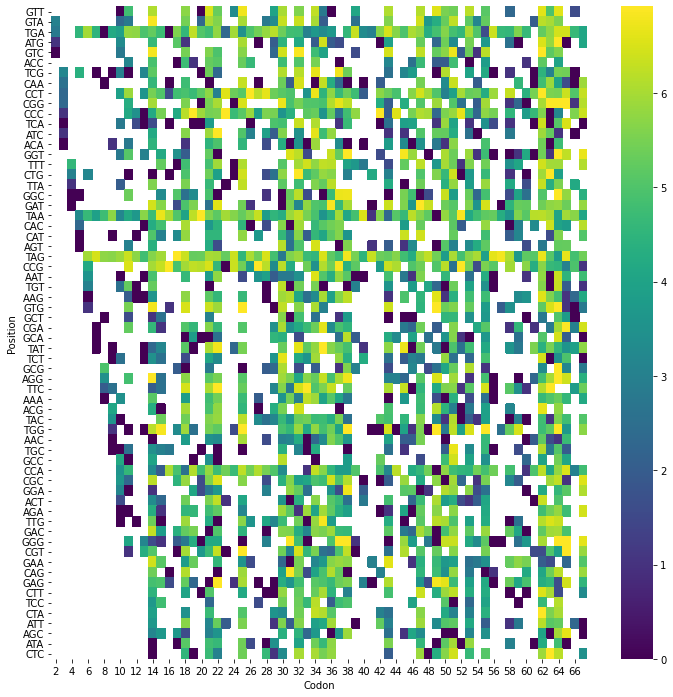

10 122522.0 4224 789 0.006439659816196275
122522.0 8.16179951355675e-06


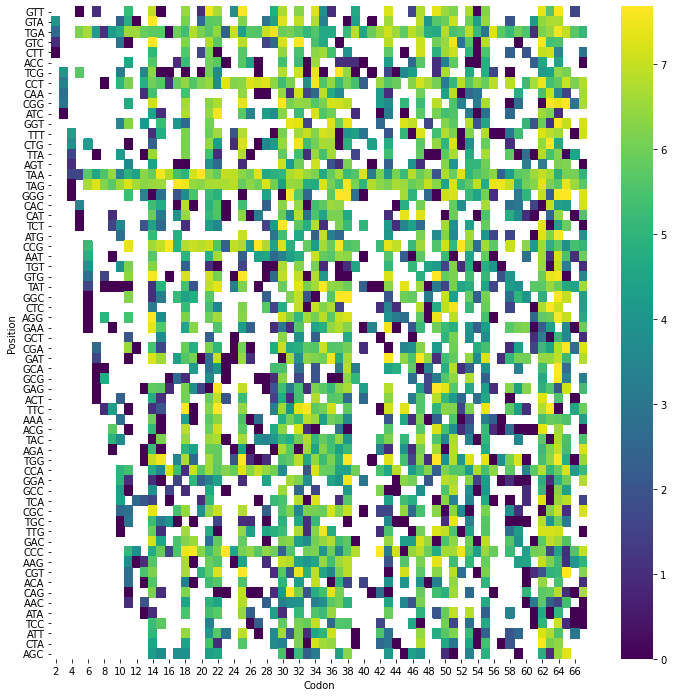

11 112246.0 4224 903 0.00804483010530442
112246.0 8.909003438875328e-06


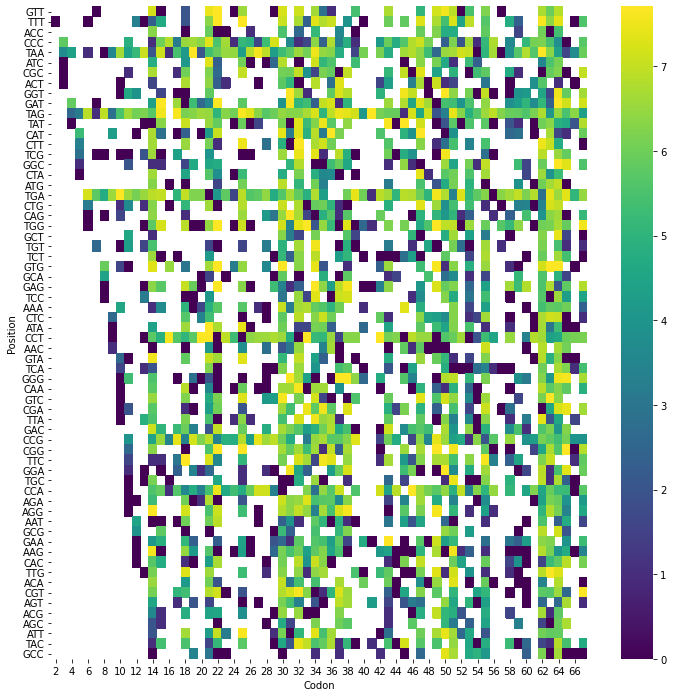

12 67561.0 4224 554 0.00819999703971226
67561.0 1.4801438699841624e-05


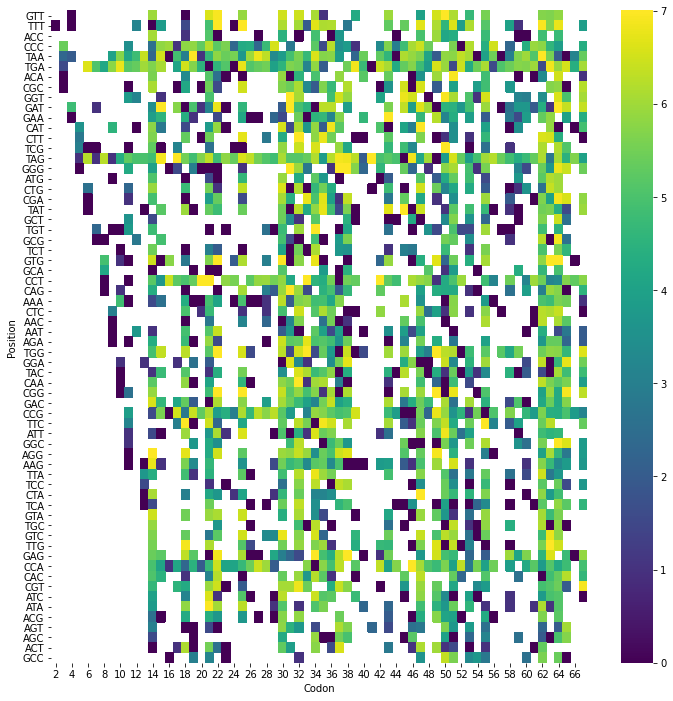

13 132270.0 4224 1077 0.008142435926513949
132270.0 7.560293339381568e-06


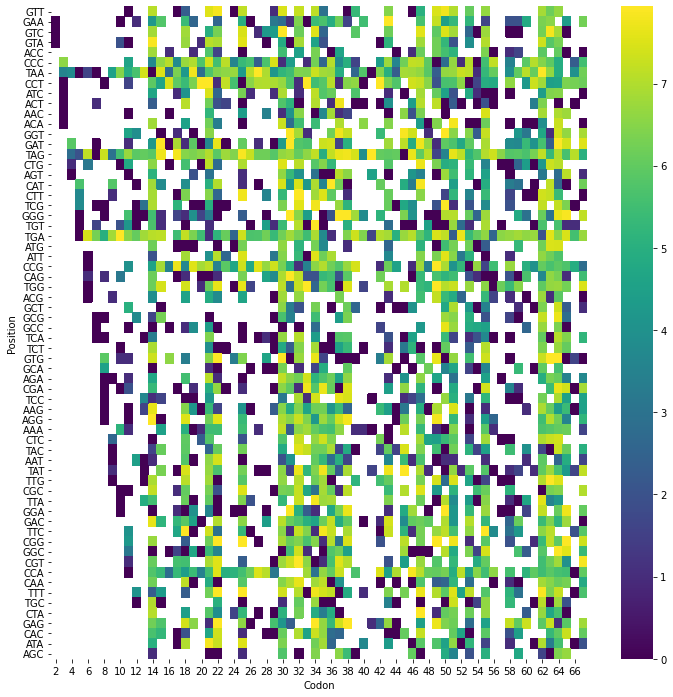

14 112513.0 3968 1457 0.012949614711188929
112513.0 8.88786184707545e-06


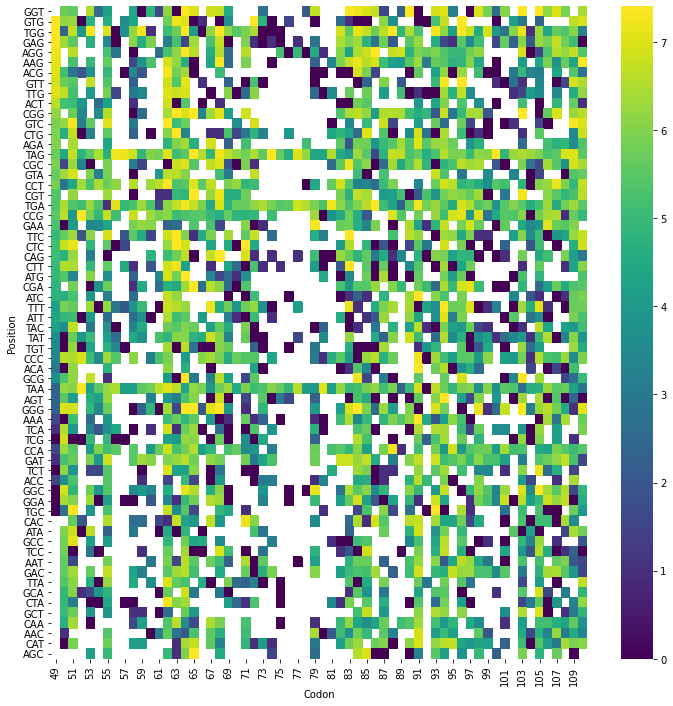

15 60086.0 3968 830 0.013813533934693607
60086.0 1.6642811969510367e-05


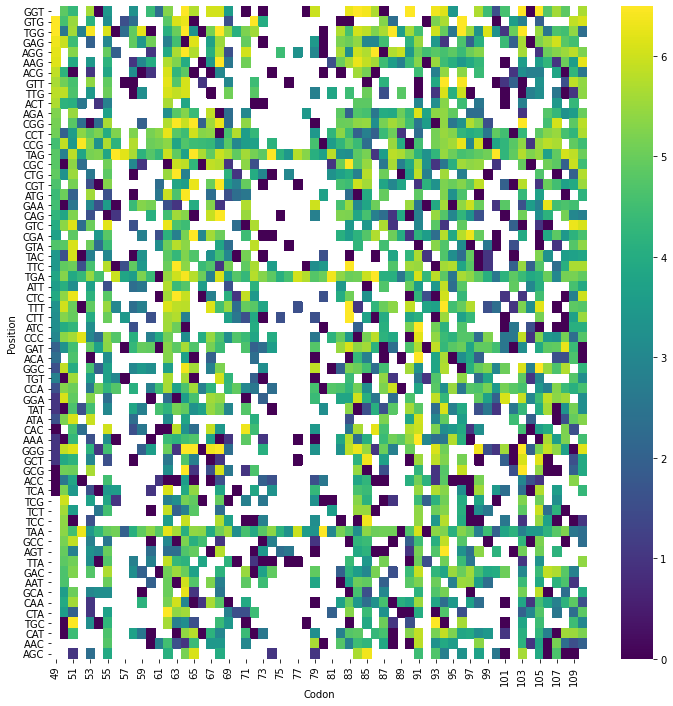

16 150675.0 3968 2198 0.014587688734030197
150675.0 6.63680106188817e-06


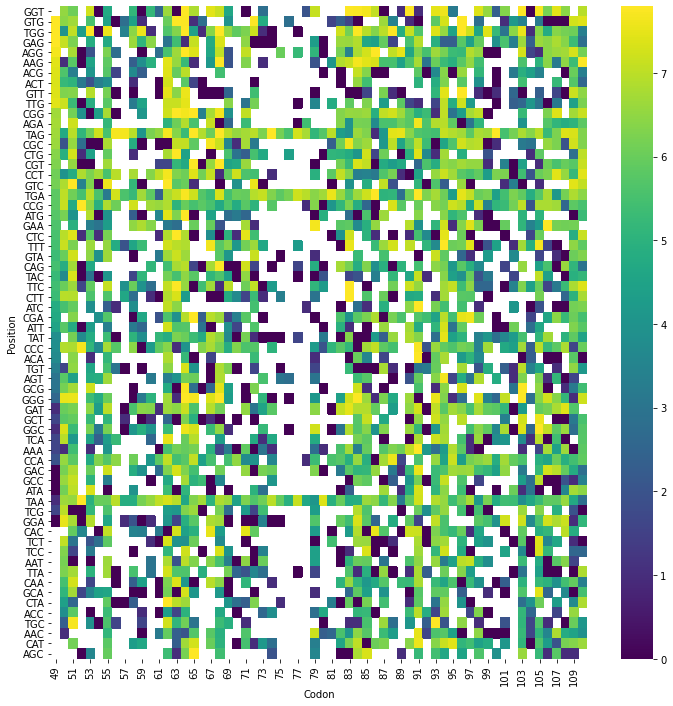

17 130306.0 3968 1927 0.014788267616226421
130306.0 7.674243703283041e-06


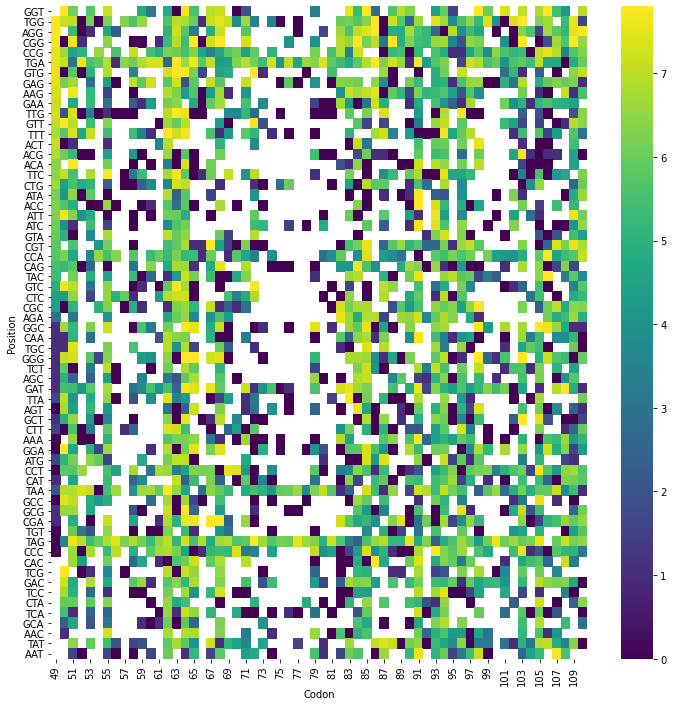

18 73301.0 3968 1058 0.014433636648886099
73301.0 1.3642378685147543e-05


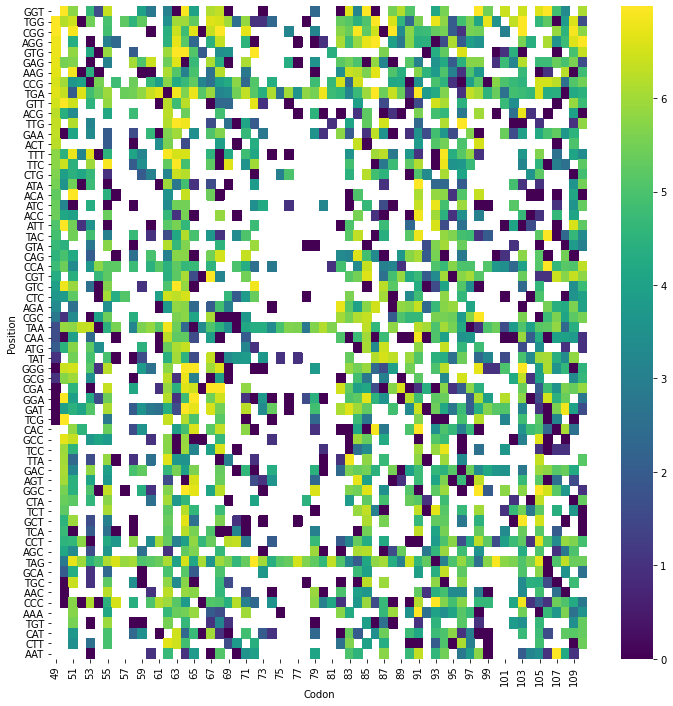

19 139086.0 3968 1929 0.013869116949225659
139086.0 7.189796241174525e-06


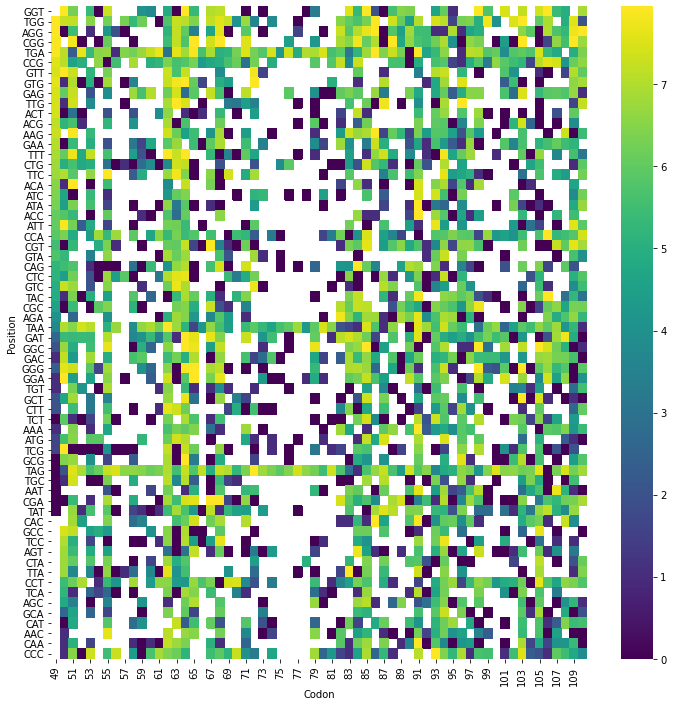

20 121587.0 4224 2018 0.016597169105249738
121587.0 8.224563481293231e-06


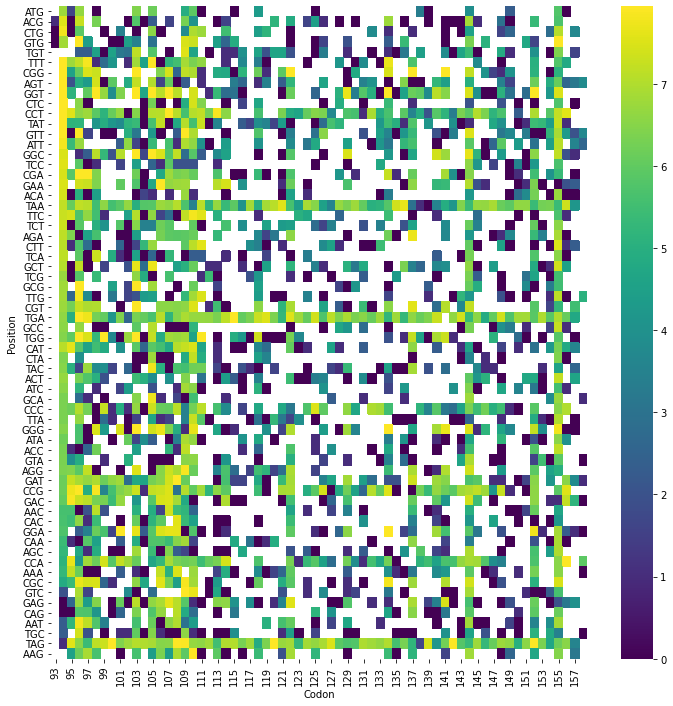

21 72065.0 4224 1123 0.015583154096995767
72065.0 1.3876361617983764e-05


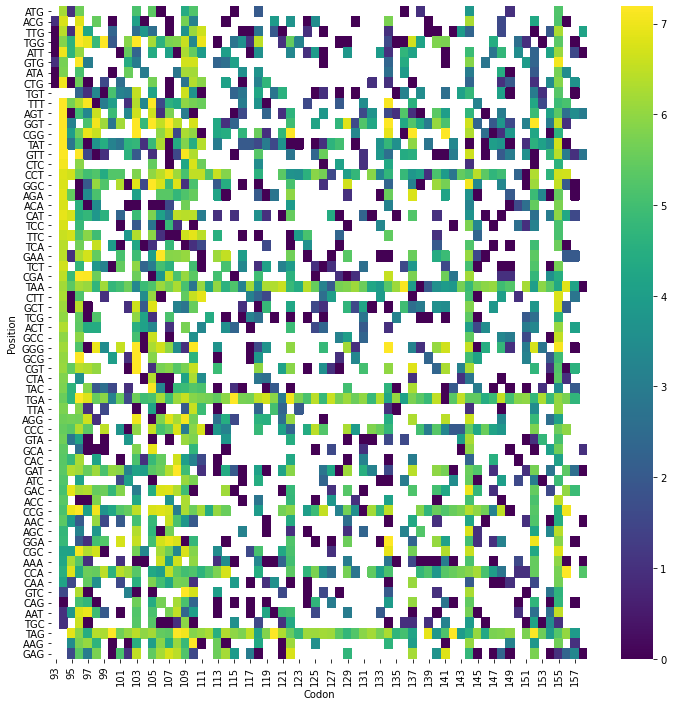

22 161127.0 4224 2679 0.016626636131747006
161127.0 6.206284483668162e-06


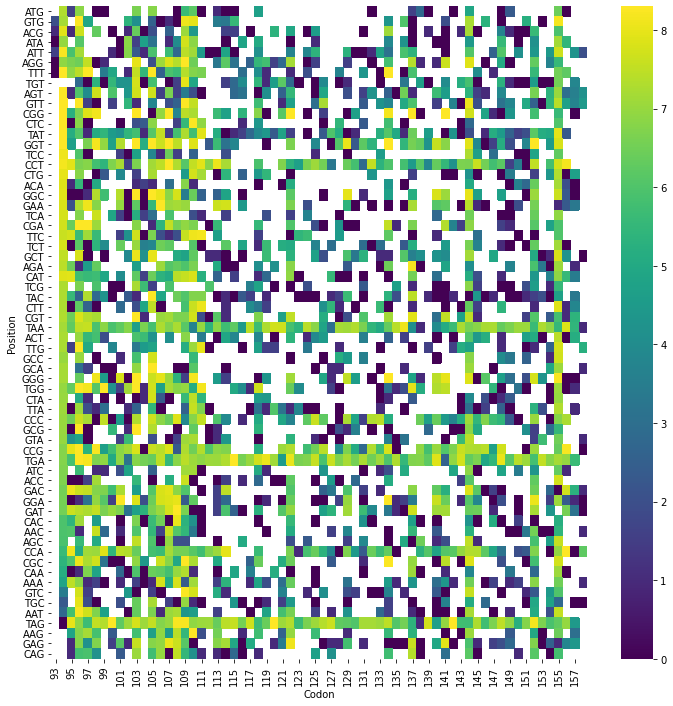

23 138124.0 4224 2073 0.015008253453418668
138124.0 7.239871419883583e-06


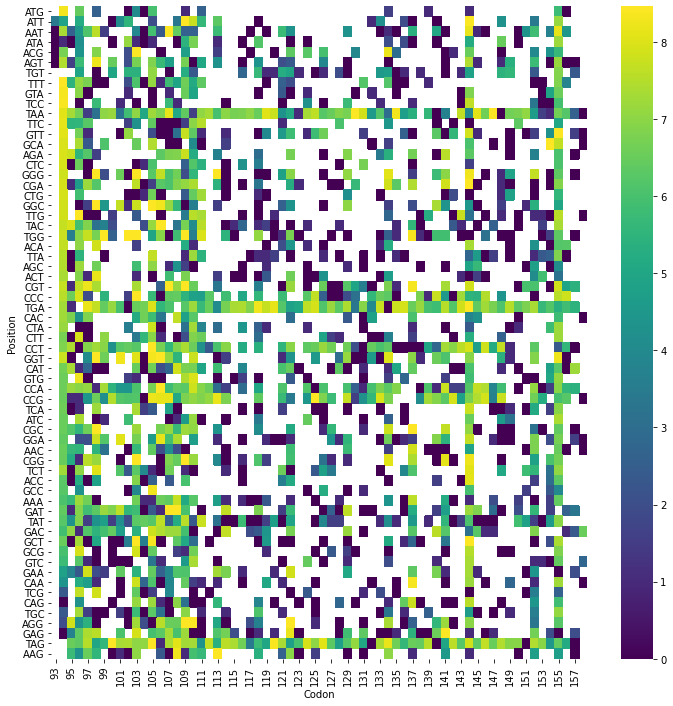

24 73318.0 4224 1147 0.015644180146757957
73318.0 1.3639215472326031e-05


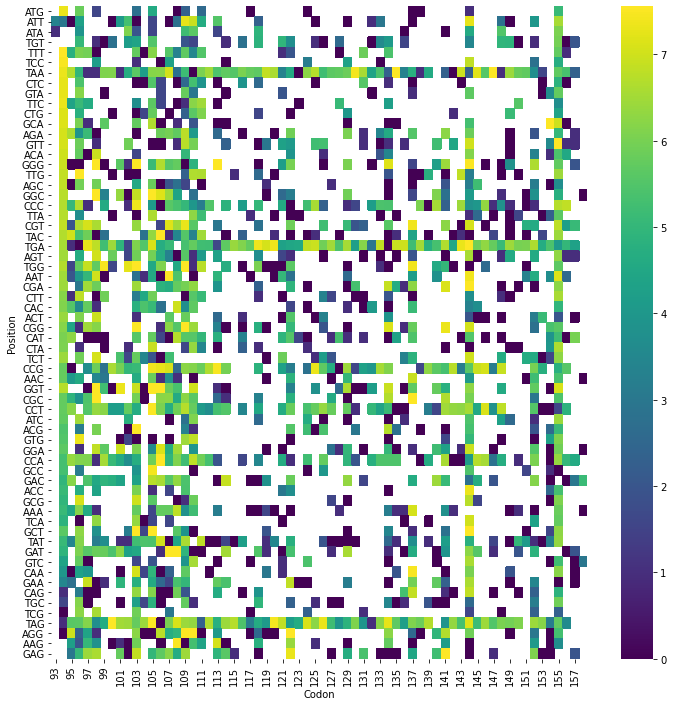

25 149286.0 4224 2486 0.016652599707943142
149286.0 6.698551773106654e-06


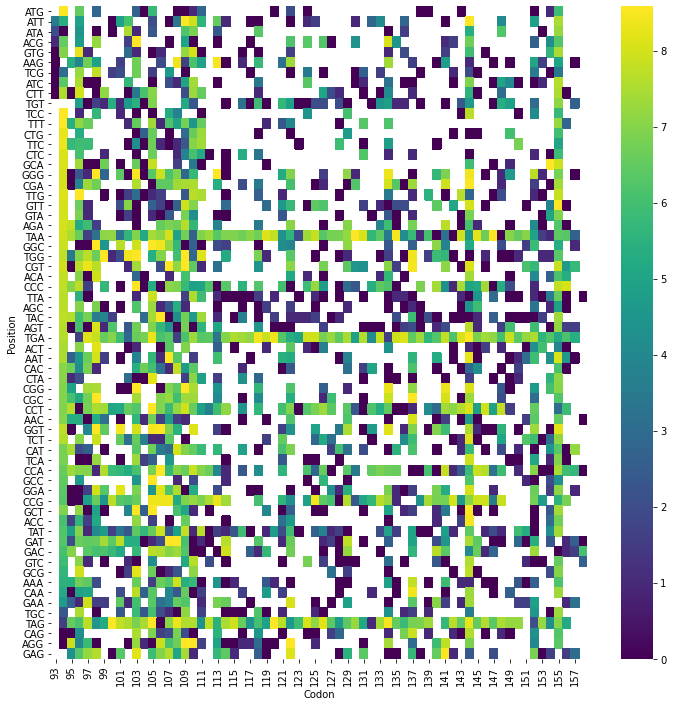

In [91]:
import seaborn as sns

for sample_ID in list(sample_dataframe.index):
    
    norm, raw = get_timepoint_fraction_df(sample_ID)
    
    plt.figure(figsize=(12,12))
    sns.heatmap(np.log2(raw), cmap='viridis', robust=True)
    plt.xlabel('Codon')
    plt.ylabel('Position')
    plt.show()
    
    

In [93]:
import seaborn as sns

In [94]:
codontable_standard = {
    'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
    'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
    'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
    'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
    'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
    'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
    'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
    'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
    'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
    'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
    'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
    'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
    'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
    'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
    'TAC':'Y', 'TAT':'Y', 'TAA':'*', 'TAG':'*',
    'TGC':'C', 'TGT':'C', 'TGA':'*', 'TGG':'W',
    }

def convert_to_aa_df(frac_df):
    
    aa_dict_of_dicts = {}
    
    codons = list(frac_df.index)
    
    for pos in list(frac_df.columns):
        
        aa_dict_of_dicts[pos] = {}
        #print(pos)
        
        for codon in codons:            
            #print(codon)
            
            aa = codontable_standard[codon]
            #print(aa_dict_of_dicts[pos])
            
            frac = frac_df.loc[codon][pos]
            
            if np.isnan(frac) == True:
                
                frac=0
            
            if aa in list(aa_dict_of_dicts[pos].keys()):           
                aa_dict_of_dicts[pos][aa] += frac
                
            else:
                aa_dict_of_dicts[pos][aa] = frac
                
    return aa_dict_of_dicts




aa_mat_a_1 = convert_to_aa_df(get_timepoint_fraction_df(8)[0])

8 126811.0 4224 886 0.006986775595177075
126811.0 7.885751236091505e-06


In [96]:
aa_order = ['V', 'F', 'G', 'C', 'W', 'L', 'S', 'R', '*', 'M', 'Q', 'A', 'Y', 'D', 'T', 'N', 'H', 'E', 'I', 'K', 'P']

<AxesSubplot:>

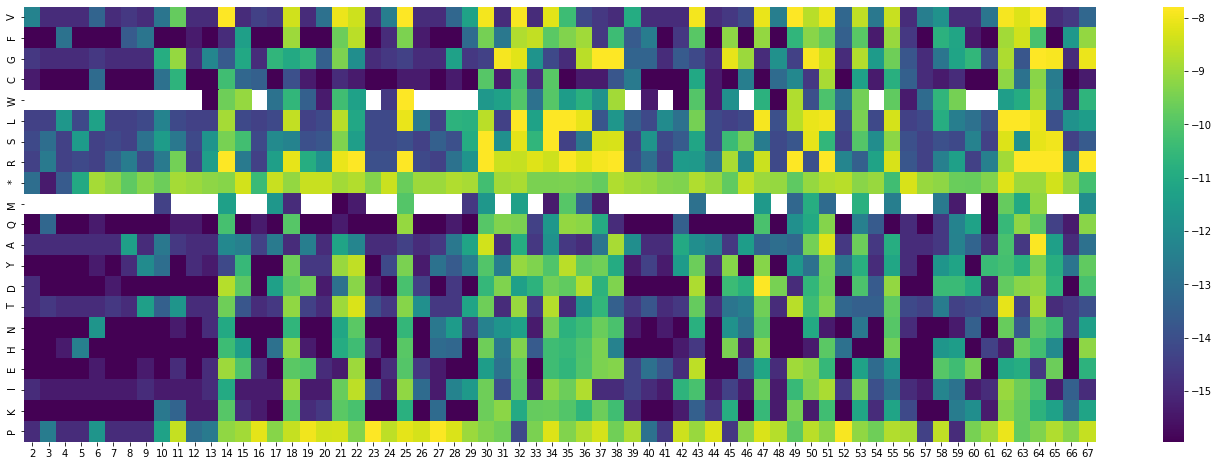

In [98]:
plt.figure(figsize=(24,8))
replaced_df = pd.DataFrame(aa_mat_a_1)
replaced_df.replace(7.885751236091505e-06, np.NaN, inplace=True)
replaced_df
sns.heatmap(np.log2(replaced_df.loc[aa_order]), robust=True, cmap='viridis')

Text(0, 0.5, 'Number of variants')

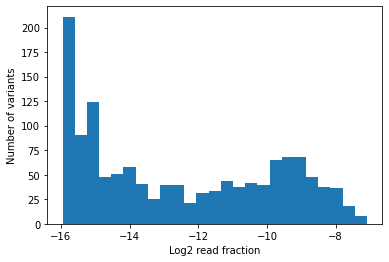

In [105]:
plt.hist(np.log2(replaced_df).to_numpy().flatten(), bins=25)

plt.xlabel('Log2 read fraction')
plt.ylabel('Number of variants')

In [ ]:
mat_a_1 = get_timepoint_fraction_df(26)[1]


In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(np.log2(mat_a_1), cmap='viridis', robust=True)
plt.xlabel('Codon')
plt.ylabel('Position')